# Head Pose Estimation Model
A Regresssion model that detects the position of a human head in the image. Particularly, it means detecting the head's Euler angles – yaw, pitch and roll. They define the object's rotation in a 3D environment.

---
### Step 0: Required Libraries


In [1]:
%%capture
!pip install mediapipe

In [2]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import skimage.io as sk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

### Step 1: Loading and exploring the dataset

We'll be using the [AFLW2000 Data](http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip) to train our model.

In [3]:
%%capture
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/Colab Notebooks/AFLW2000-3D.zip" -d "/content/"

In [4]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img
     

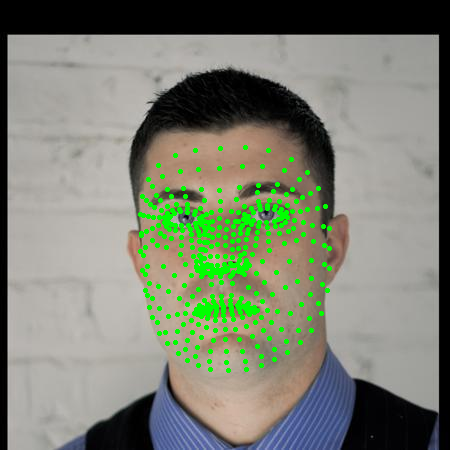

In [5]:
# choosing random image
random_file = 'image00014'

def medimg(random_file):
    faceModule = mediapipe.solutions.face_mesh
    # loading image and its correspinding mat file
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        # loading the image
        image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
        
        # processing the face to extract the landmark points (468 point) for each x,y,z
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None: 
          # looping over the faces in the image
          # i=0
          for face in results.multi_face_landmarks:
              for landmark in face.landmark:
                  x = landmark.x
                  y = landmark.y
                  # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                  shape = image.shape 
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  nose_x = int(face.landmark[1].x * image.shape[1])
                  nose_y = int(face.landmark[1].y * image.shape[0])
                  # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                  cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
          cv2_imshow(image)
          return nose_x,nose_y

nose_x,nose_y=medimg(random_file)

<class 'numpy.ndarray'> (450, 450, 3)


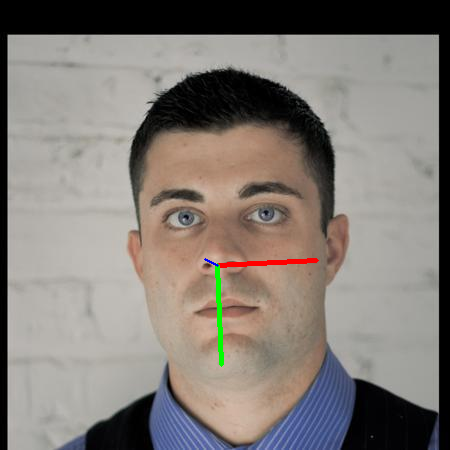

In [6]:
def get_pose_para(img_name):
    image = cv2.imread('/content/AFLW2000/'+img_name+'.jpg')
    # loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
    mat_file = sio.loadmat('/content/AFLW2000/'+img_name+'.mat')
    # extracting the labels 3 angels
    pose_para = mat_file["Pose_Para"][0][:3]
    # print(pose_para)
    pitch = pose_para[0]
    yaw = pose_para[1]
    roll = pose_para[2]
    return pitch,yaw,roll,image

pitch,yaw,roll,image=  get_pose_para(random_file)  
axis=draw_axis(image,pitch,yaw,roll,nose_x,nose_y)
print(type(axis),axis.shape)
cv2_imshow(draw_axis(image,pitch,yaw,roll,nose_x,nose_y))

image00002


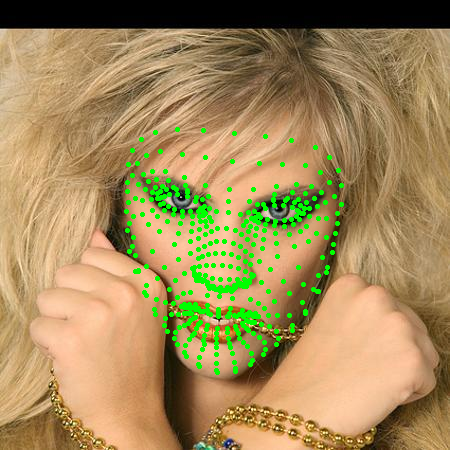

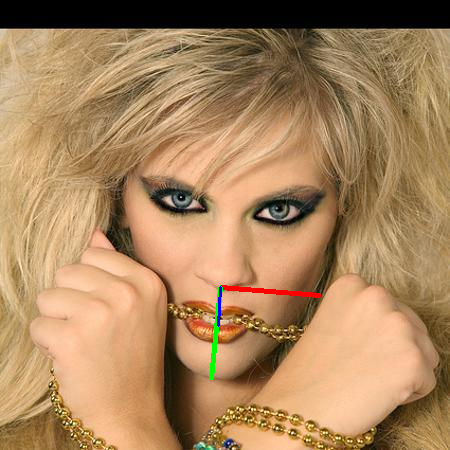

image00004


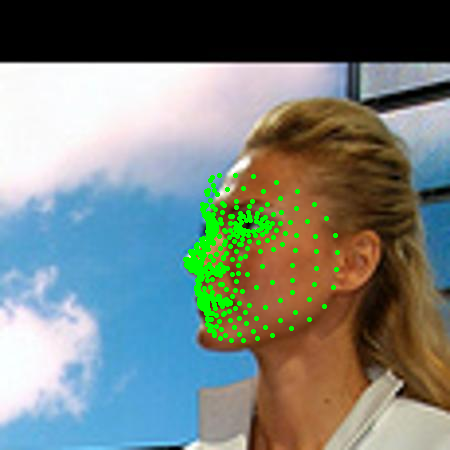

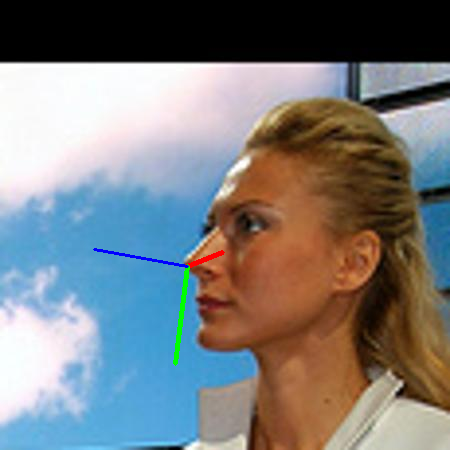

In [7]:
data_dir = '/content/AFLW2000/'

files = glob.glob(os.path.join(data_dir, '*.jpg'))
img_names=[]
for i in range(len(files)):
    img_names.append(files[i].split("/")[3].split(".")[0])
img_names.sort()

for i in range(2):
  print(img_names[i])
  image = cv2.imread('/content/AFLW2000/'+img_names[i]+'.jpg')
  nose_x,nose_y = medimg(img_names[i])
  pitch,yaw,roll,image =  get_pose_para(img_names[i])  
  cv2_imshow(draw_axis(image,pitch,yaw,roll,nose_x,nose_y))
  

### Step 2: Extracting features and labels

We'll be using the x,y coordinates resulting from mediapipe face.mesh and we have 3 seperate labels yaw,pitch and roll to train three models.

In [8]:
# img_names

In [9]:
# Extracting features
x_points= []
y_points = []
pitch_label=[]
yaw_label=[]
roll_label=[]
x_scaled= []
y_scaled = []
img_detected=[]

faceModule = mediapipe.solutions.face_mesh

for img_name in img_names: 
  # loading image 
  with faceModule.FaceMesh(static_image_mode=False,refine_landmarks=False ) as faces:
      # loading the image
      image = cv2.imread('/content/AFLW2000/'+img_name+'.jpg')
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None:
        # face = results.multi_face_landmarks[0]
        X=[]
        Y=[]
        X_scaled=[]
        Y_scaled=[]
        for face in results.multi_face_landmarks:
          nose_x = int(face.landmark[1].x * image.shape[1])
          nose_y = int(face.landmark[1].y * image.shape[0])
          chin_x =  int(face.landmark[152].x * image.shape[1])
          chin_y = int(face.landmark[152].y * image.shape[0])
          head_x =  int(face.landmark[10].x * image.shape[1])
          head_y = int(face.landmark[10].y * image.shape[0])
          for landmark in face.landmark:
            x = landmark.x
            y = landmark.y
            # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
            shape = image.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
            X.append(relative_x)
            Y.append(relative_y)
            distance = np.linalg.norm(np.array((head_x,head_y)) - np.array((chin_x,chin_y)))
            # print(distance)
            # distance1 = ((nose_x - chin_x)**2 + (nose_y - chin_y)**2)**0.5
            # print(distance1)
            scaled_x= (relative_x - nose_x) / distance
            scaled_y= (relative_y - nose_y) / distance
            X_scaled.append(scaled_x)
            Y_scaled.append(scaled_y)
        
          img_detected.append(img_name)
          x_points.append(X)
          y_points.append(Y)
          x_scaled.append(X_scaled)
          y_scaled.append(Y_scaled)

          mat_file = sio.loadmat('/content/AFLW2000/'+img_name+'.mat')
          pose_para = mat_file["Pose_Para"][0][:3]
          pitch = pose_para[0]
          yaw = pose_para[1]
          roll = pose_para[2]
          pitch_label.append(pitch)
          yaw_label.append(yaw)
          roll_label.append(roll) 

In [10]:
print(x_points[0])
print(y_points[0])
print(x_scaled[0])
print(y_scaled[0])

[218, 220, 220, 215, 220, 222, 226, 163, 228, 229, 234, 218, 218, 218, 217, 216, 216, 216, 216, 220, 212, 132, 192, 182, 173, 160, 199, 176, 187, 166, 160, 152, 185, 159, 127, 142, 178, 207, 208, 195, 189, 200, 195, 178, 213, 212, 148, 198, 194, 194, 152, 213, 168, 156, 141, 208, 196, 173, 138, 200, 207, 181, 186, 152, 194, 185, 184, 177, 146, 182, 143, 137, 207, 198, 192, 202, 184, 186, 187, 204, 197, 203, 210, 204, 203, 204, 206, 207, 195, 193, 190, 188, 183, 129, 220, 191, 189, 209, 196, 208, 190, 174, 193, 155, 160, 165, 184, 205, 205, 203, 164, 142, 203, 152, 205, 199, 133, 148, 159, 178, 191, 199, 217, 133, 145, 215, 198, 127, 206, 192, 157, 199, 132, 203, 206, 154, 155, 127, 144, 132, 184, 216, 190, 135, 174, 182, 184, 135, 199, 177, 167, 232, 217, 190, 198, 202, 138, 195, 187, 177, 169, 164, 128, 168, 219, 190, 200, 207, 228, 164, 174, 198, 146, 200, 210, 216, 186, 129, 200, 198, 196, 194, 192, 190, 187, 184, 177, 146, 211, 209, 204, 192, 146, 216, 189, 223, 216, 224, 202, 216,

In [11]:
len(x_points),len(y_points), len(pitch_label),len(yaw_label),len(roll_label),len(x_scaled),len(y_scaled),len(img_detected)

(1853, 1853, 1853, 1853, 1853, 1853, 1853, 1853)

In [12]:
for x_arr,y_arr in zip(x_points,y_points):
  if len(x_arr) != 468 or len(y_arr) != 468:
    print(x_arr,y_arr)

In [13]:
features=np.hstack((x_points,y_points))
scaled_features=np.hstack((x_scaled,y_scaled))

In [14]:
len(features)

1853

In [15]:
np_features=np.array(features)
np_scaled_features=np.array(scaled_features)
np_yaw_label=np.array(yaw_label).reshape(-1,1)
np_pitch_label=np.array(pitch_label).reshape(-1,1)
np_roll_label=np.array(roll_label).reshape(-1,1)

In [16]:
np_features.shape, np_scaled_features.shape ,np_yaw_label.shape ,np_pitch_label.shape ,np_roll_label.shape

((1853, 936), (1853, 936), (1853, 1), (1853, 1), (1853, 1))

In [17]:
labels=np.concatenate((np_yaw_label,np_pitch_label,np_roll_label),axis=1)

### Step 3: Training our models
#### Importing dependencies 


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

#### Splitting the data
Split the data into train and test only as i was planning to use the grid search method which applies cross validation.
 

In [19]:
x_yaw_train, x_yaw_test, y_yaw_train, y_yaw_test= train_test_split(np_scaled_features, np_yaw_label, test_size=0.3,random_state=84)

In [20]:
x_pitch_train, x_pitch_test, y_pitch_train, y_pitch_test = train_test_split(np_scaled_features, np_pitch_label, test_size=0.3,random_state=84)

In [21]:
x_roll_train, x_roll_test, y_roll_train, y_roll_test,img_train,img_test  = train_test_split(np_scaled_features, np_roll_label,img_detected, test_size=0.3,random_state=42)

#### Choosing my model
##### Yaw Models

In [ ]:
yaw_LR_model=LinearRegression().fit(x_yaw_train, y_yaw_train)
yaw_SVR_model=SVR().fit(x_yaw_train, y_yaw_train)
yaw_XG_model=XGBRegressor().fit(x_yaw_train, y_yaw_train)

[23:26:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Will use svr
print("LR score=",mean_absolute_error(yaw_LR_model.predict(x_yaw_test),y_yaw_test))
print("SVR score= ",mean_absolute_error(yaw_SVR_model.predict(x_yaw_test),y_yaw_test))
print("XGBoost score= ",mean_absolute_error(yaw_XG_model.predict(x_yaw_test),y_yaw_test))
print("LR score=", yaw_LR_model.score(x_yaw_test, y_yaw_test))
print("SVR score=", yaw_SVR_model.score(x_yaw_test, y_yaw_test))
print("XGBoost score=", yaw_XG_model.score(x_yaw_test, y_yaw_test))

LR score= 0.33574866659906394
SVR score=  0.06669640945557767
XGBoost score=  0.08338147471783076
LR score= 0.4359286154521901
SVR score= 0.955030668236356
XGBoost score= 0.9091218465434937


##### Roll Models

In [ ]:
roll_LR_model=LinearRegression().fit(x_roll_train, y_roll_train)
roll_SVR_model=SVR().fit(x_roll_train, y_roll_train)
roll_XG_model=XGBRegressor().fit(x_roll_train, y_roll_train)

[23:43:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Use SVR
print("LR score=",mean_absolute_error(roll_LR_model.predict(x_roll_test),y_roll_test))
print("SVR score= ",mean_absolute_error(roll_SVR_model.predict(x_roll_test),y_roll_test))
print("XGBoost score= ",mean_absolute_error(roll_XG_model.predict(x_roll_test),y_roll_test))
print("LR score=", roll_LR_model.score(x_roll_test, y_roll_test))
print("SVR score=", roll_SVR_model.score(x_roll_test, y_roll_test))
print("XGBoost score=", roll_XG_model.score(x_roll_test, y_roll_test))

LR score= 0.6350887317585442
SVR score=  0.07206833148385906
XGBoost score=  0.13271714562649173
LR score= -3.689191974276839
SVR score= 0.6786152847044298
XGBoost score= -5.334355889255391


##### Pitch Models

In [ ]:
pitch_LR_model=LinearRegression().fit(x_pitch_train, y_pitch_train)
pitch_SVR_model=SVR().fit(x_pitch_train, y_pitch_train)
pitch_XG_model=XGBRegressor().fit(x_pitch_train, y_pitch_train)

[23:29:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
# Use SVR
print("LR score=",mean_absolute_error(pitch_LR_model.predict(x_pitch_test),y_pitch_test))
print("SVR score= ",mean_absolute_error(pitch_SVR_model.predict(x_pitch_test),y_pitch_test))
print("XGBoost score= ",mean_absolute_error(pitch_XG_model.predict(x_pitch_test),y_pitch_test))
print("LR score=", pitch_LR_model.score(x_pitch_test, y_pitch_test))
print("SVR score=", pitch_SVR_model.score(x_pitch_test, y_pitch_test))
print("XGBoost score=", pitch_XG_model.score(x_pitch_test, y_pitch_test))

#### Grid Search to get best results
##### Yaw Model

In [22]:
C_range = [0.1,1,10,100]
param_grid = dict(C=C_range,kernel=('poly','rbf','sigmoid'),coef0=[0,1])
yaw_model = GridSearchCV(SVR(), param_grid=param_grid, cv=5,n_jobs=-1).fit(x_yaw_train, y_yaw_train)

print("The best parameters are %s with a score of %0.2f" % (yaw_model.best_params_, yaw_model.best_score_))

The best parameters are {'C': 10, 'coef0': 0, 'kernel': 'poly'} with a score of 0.85


In [23]:
print("Train Error: ",mean_absolute_error(yaw_model.predict(x_yaw_train),y_yaw_train))
print("Test Error: ",mean_absolute_error(yaw_model.predict(x_yaw_test),y_yaw_test))
print("SVR test score=", yaw_model.score(x_yaw_test, y_yaw_test))

Train Error:  0.07080159432711221
Test Error:  0.06592807618159406
SVR test score= 0.9612314437434457


In [ ]:
import joblib
filename = 'yaw_model2.sav'
joblib.dump(yaw_model, open(filename, 'wb'))

##### Roll Model

In [24]:
C_range = [0.1,1,10,100]
param_grid = dict(C=C_range,kernel=('poly','rbf','sigmoid'),coef0=[0,1])
roll_model = GridSearchCV(SVR(), param_grid=param_grid, cv=5,n_jobs=-1).fit(x_roll_train, y_roll_train)

print("The best parameters are %s with a score of %0.2f" % (roll_model.best_params_, roll_model.best_score_))

The best parameters are {'C': 1, 'coef0': 0, 'kernel': 'rbf'} with a score of 0.50


In [25]:
# The best parameters are {'C': 1, 'coef0': 0, 'kernel': 'poly'} with a score of 0.55
print("Train Error: ",mean_absolute_error(roll_model.predict(x_roll_train),y_roll_train))
print("Test Error: ",mean_absolute_error(roll_model.predict(x_roll_test),y_roll_test))
print("SVR test score=", roll_model.score(x_roll_test, y_roll_test))


Train Error:  0.08515644687956371
Test Error:  0.07206833148385906
SVR test score= 0.6786152847044298


In [ ]:
import joblib
filename = 'roll_model2.sav'
joblib.dump(roll_model, open(filename, 'wb'))

##### Pitch Model

In [26]:
C_range = [0.1,1,10,100]
param_grid = dict(C=C_range,kernel=('poly','rbf','sigmoid'),coef0=[0,1])
pitch_model = GridSearchCV(SVR(), param_grid=param_grid, cv=5,n_jobs=-1).fit(x_pitch_train, y_pitch_train)

print("The best parameters are %s with a score of %0.2f" % (pitch_model.best_params_, pitch_model.best_score_))

The best parameters are {'C': 1, 'coef0': 1, 'kernel': 'poly'} with a score of 0.45


In [ ]:
pitch_model=SVR(C=10,coef0=0,kernel='poly').fit(x_pitch_train, y_pitch_train)

In [27]:
print("Train Error: ",mean_absolute_error(pitch_model.predict(x_pitch_train),y_pitch_train))
print("Test Error: ",mean_absolute_error(pitch_model.predict(x_pitch_test),y_pitch_test))
print("SVR test score=", pitch_model.score(x_pitch_test, y_pitch_test))
print("SVR test score=", pitch_model.score(x_pitch_train, y_pitch_train))

Train Error:  0.1035674383345149
Test Error:  0.08548325540307036
SVR test score= 0.7056043643964537
SVR test score= 0.1629479449056358


In [ ]:
import joblib
filename = 'pitch_model2.sav'
joblib.dump(pitch_model, open(filename, 'wb'))

### Step 4: Testing the models
Testing the model using both random imgs from the internet and imgs from the test set to compare model results with real results.

In [28]:
len(img_train),len(x_yaw_train),len(img_test),len(y_yaw_test)

(1297, 1297, 556, 556)

In [43]:
# Extracting features for images returns 
# nose_x,nose_y and a numpy array of the features 

def get_feat(image):

  x_scaled= []
  y_scaled = []

  faceModule = mediapipe.solutions.face_mesh

  with faceModule.FaceMesh(static_image_mode=False,refine_landmarks=False) as faces:
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None:
        face = results.multi_face_landmarks[0]
        X_scaled=[]
        Y_scaled=[]
        nose_x = int(face.landmark[1].x * image.shape[1])
        nose_y = int(face.landmark[1].y * image.shape[0])
        head_x =  int(face.landmark[10].x * image.shape[1])
        head_y = int(face.landmark[10].y * image.shape[0])
        chin_x =  int(face.landmark[152].x * image.shape[1])
        chin_y = int(face.landmark[152].y * image.shape[0])
        distance = np.linalg.norm(np.array((chin_x,chin_y)) - np.array((head_x,head_y)))
        for landmark in face.landmark:
          x = landmark.x
          y = landmark.y
          # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
          shape = image.shape 
          relative_x = int(x * shape[1])
          relative_y = int(y * shape[0])

          # print(distance)
          scaled_x= (relative_x - nose_x) / distance
          scaled_y= (relative_y - nose_y) / distance
          X_scaled.append(scaled_x)
          Y_scaled.append(scaled_y)

        x_scaled.append(X_scaled)
        y_scaled.append(Y_scaled)
      
        feat=np.hstack((x_scaled,y_scaled))
        feat=np.array(feat).reshape(1, -1)

      return nose_x,nose_y,feat,distance


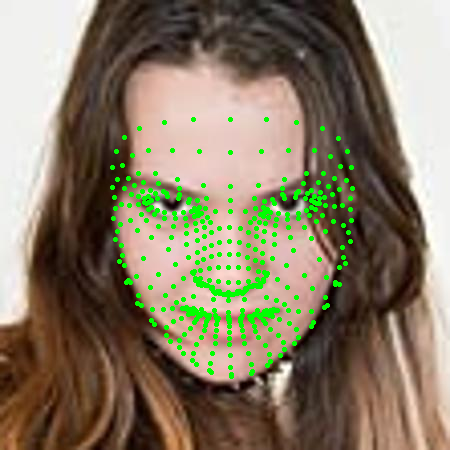

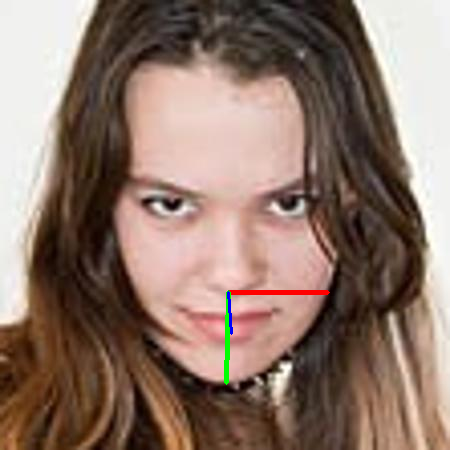

----------------------Model Output---------------------------


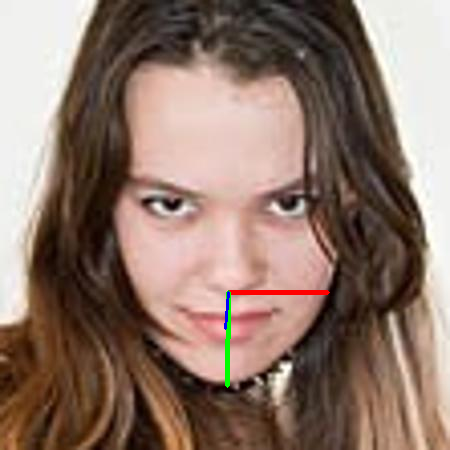

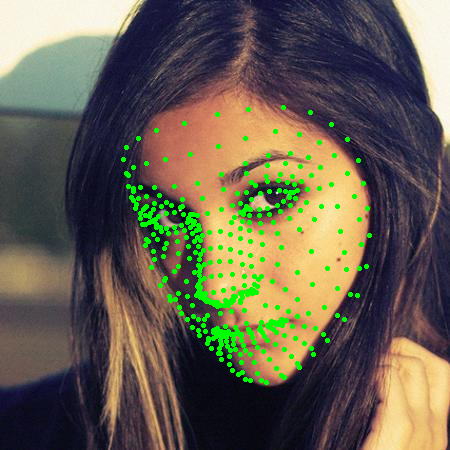

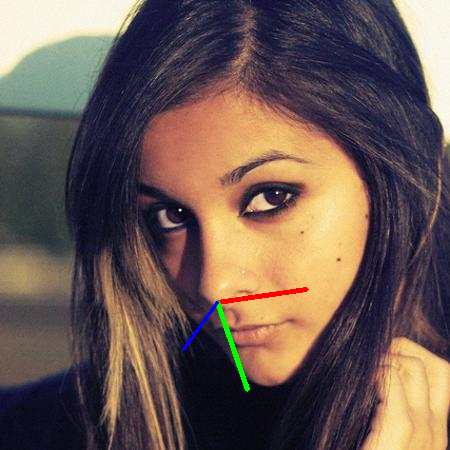

----------------------Model Output---------------------------


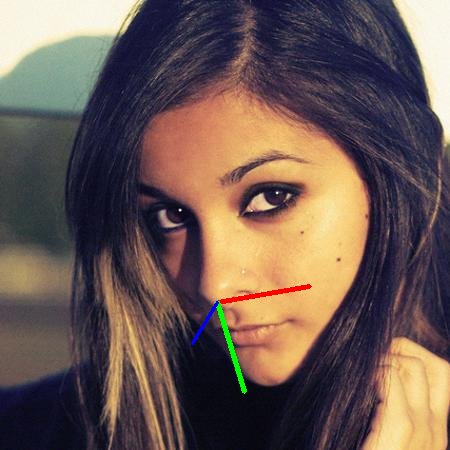

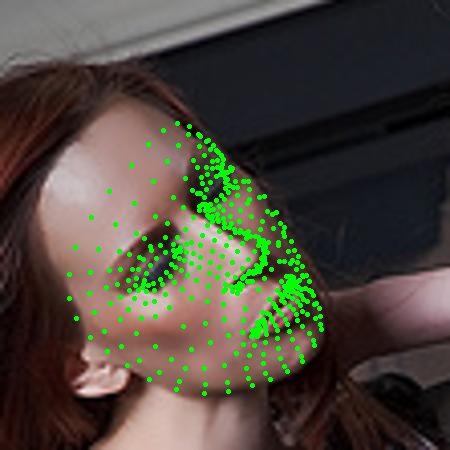

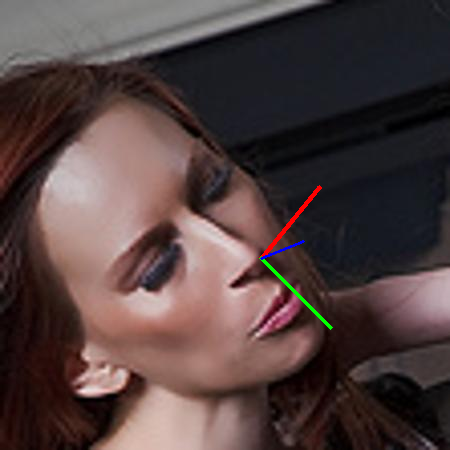

----------------------Model Output---------------------------


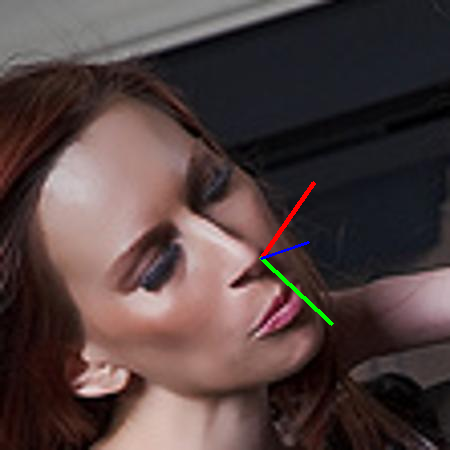

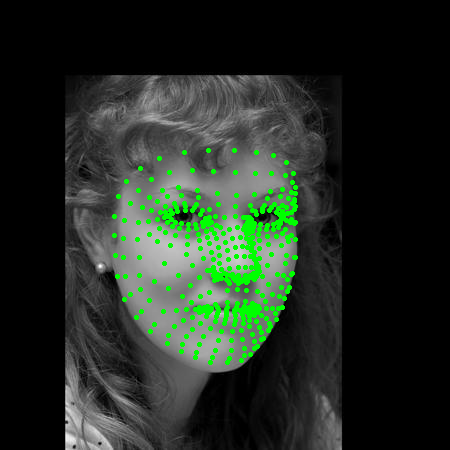

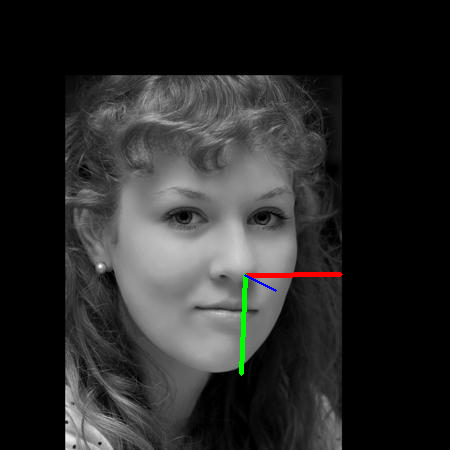

----------------------Model Output---------------------------


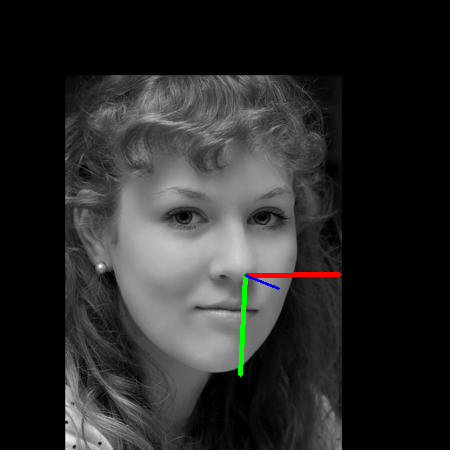

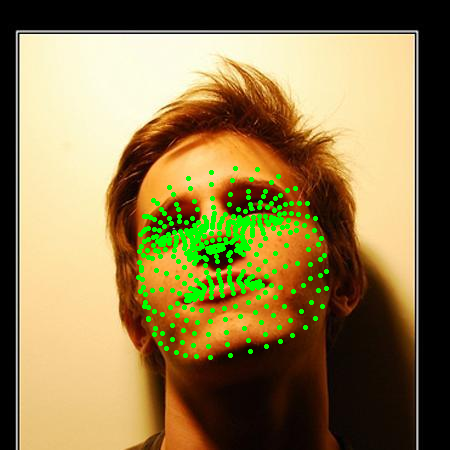

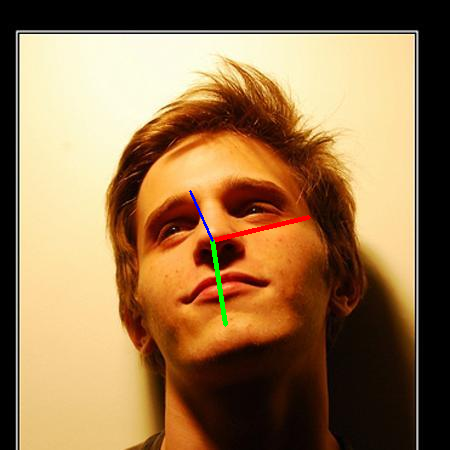

----------------------Model Output---------------------------


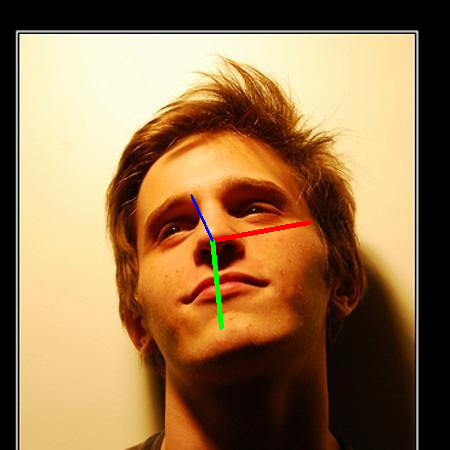

In [54]:
for i in range(5):
  random_file = img_test[i]
  nose_x,nose_y=medimg(random_file)
  pitch,yaw,roll,image=  get_pose_para(random_file)  
  cv2_imshow(draw_axis(image,pitch,yaw,roll,nose_x,nose_y))
  print("----------------------Model Output---------------------------")
  image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
  nose_x,nose_y,feat,_=get_feat(image)
  yaw = yaw_model.predict(feat)
  pitch = pitch_model.predict(feat)
  roll = roll_model.predict(feat)
  image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
  cv2_imshow(draw_axis(image,pitch,yaw,roll,nose_x,nose_y))

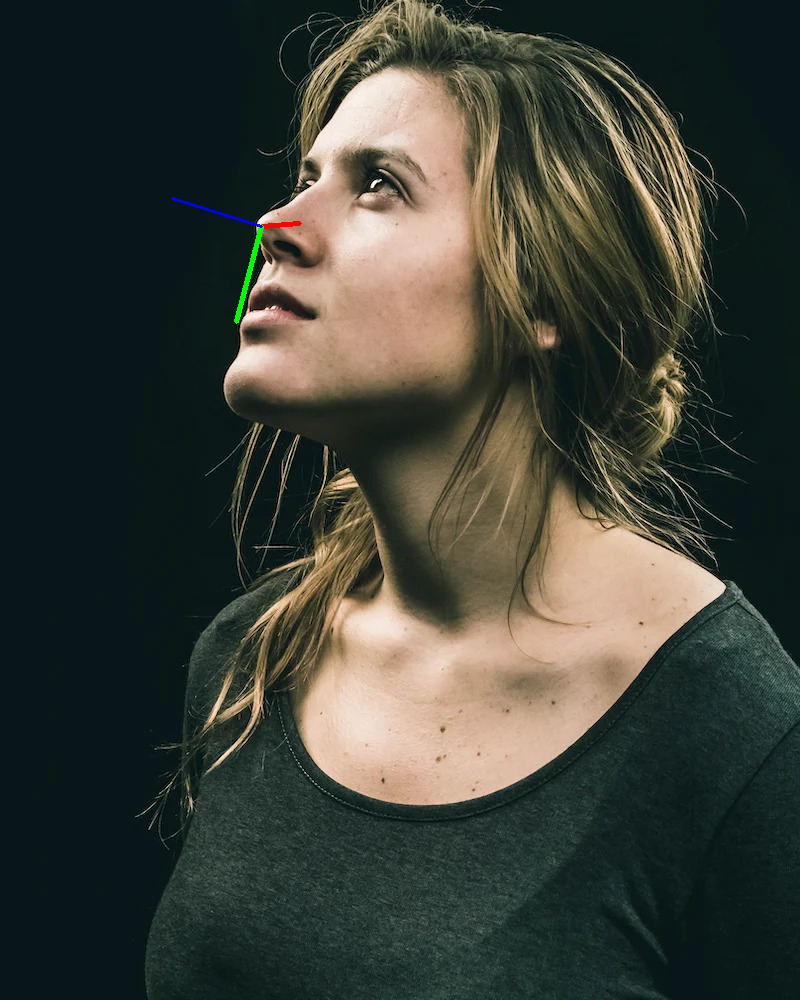

In [ ]:
image = cv2.imread('/content/drive/MyDrive/girllll.jpeg')
nose_x,nose_y,feat,_=get_feat(image)
yaw = yaw_model.predict(feat)
pitch = pitch_model.predict(feat)
roll = roll_model.predict(feat)
image = cv2.imread('/content/drive/MyDrive/girllll.jpeg')
cv2_imshow(draw_axis(image,pitch,yaw,roll,nose_x,nose_y))

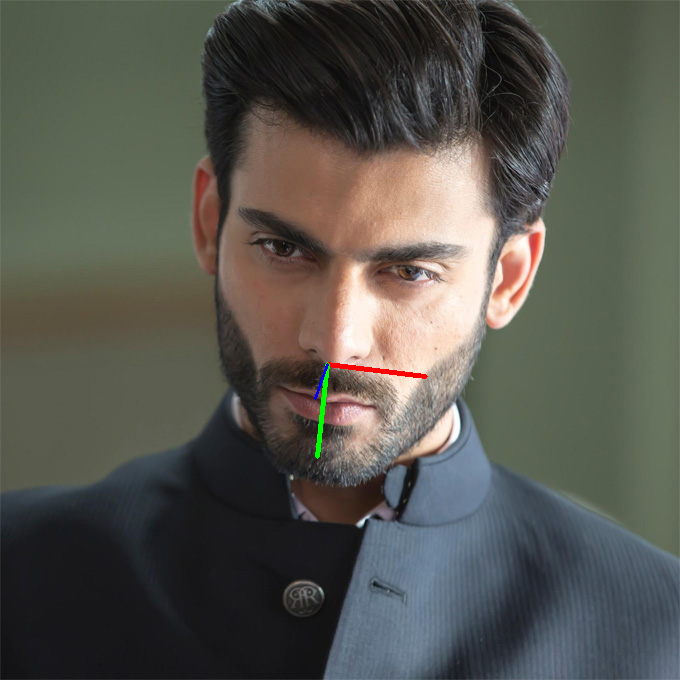

In [ ]:
image = cv2.imread('/content/drive/MyDrive/training_img (3).jpg')
nose_x,nose_y,feat,_=get_feat(image)
yaw = yaw_model.predict(feat)
pitch = pitch_model.predict(feat)
roll = roll_model.predict(feat)
image = cv2.imread('/content/drive/MyDrive/training_img (3).jpg')
cv2_imshow(draw_axis(image,pitch,yaw,roll,nose_x,nose_y))

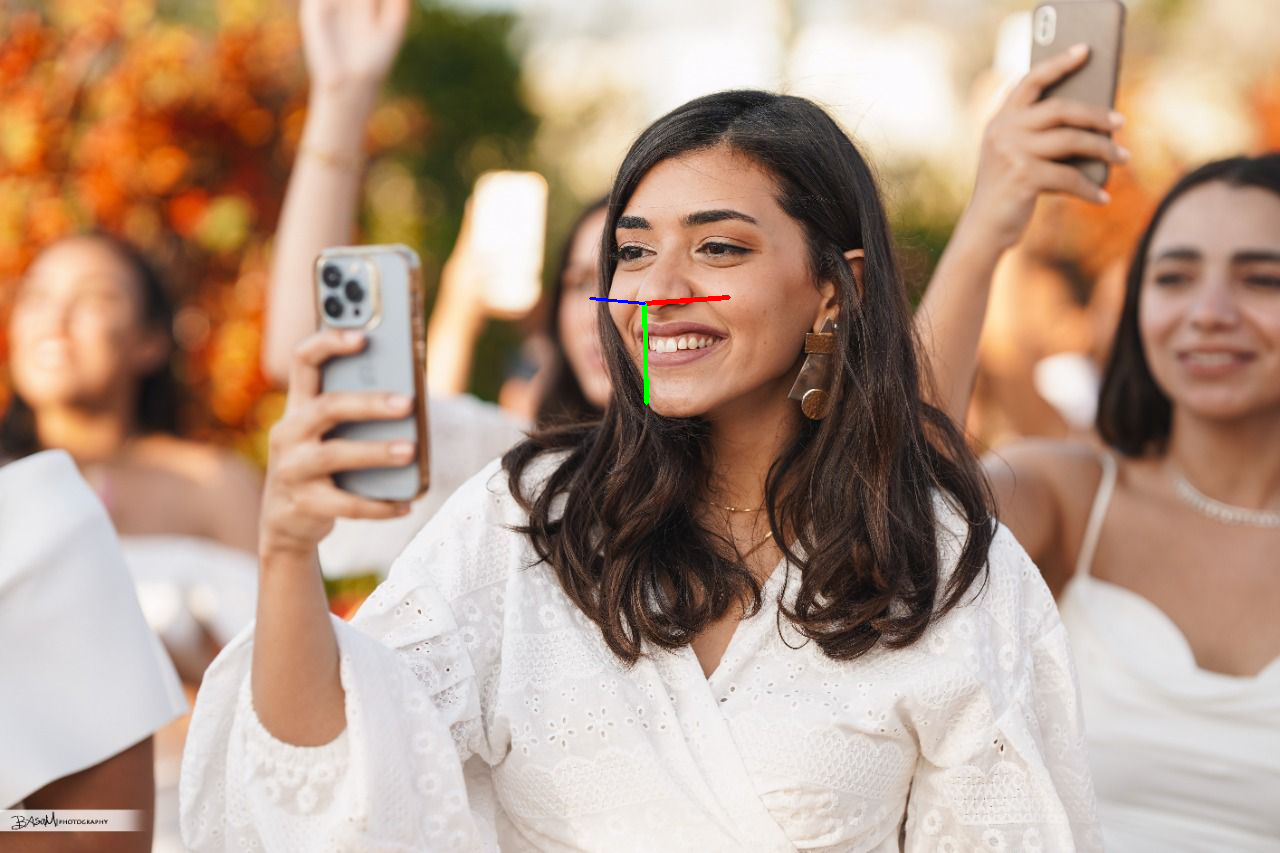

In [45]:
image = cv2.imread('/content/drive/MyDrive/Training_img(6).jpeg')
nose_x,nose_y,feat,_=get_feat(image)
yaw = yaw_model.predict(feat)
pitch = pitch_model.predict(feat)
roll = roll_model.predict(feat)
image = cv2.imread('/content/drive/MyDrive/Training_img(6).jpeg')
cv2_imshow(draw_axis(image,pitch,yaw,roll,nose_x,nose_y))

In [51]:
# Avoided using get_features function in the video due to the time comlexity and overhead of function call
img_array=[]

cap = cv2.VideoCapture('/content/WhatsApp Video 2023-02-25 at 1.09.09 AM (1).mp4')

i=0 #frame counter
frameTime = 1 # time of each frame in ms, you can add logic to change this value.

cap.set(cv2.CAP_PROP_FPS, 30)
cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'MJPG'))

with faceModule.FaceMesh(static_image_mode=False,refine_landmarks=False) as faces:
  while(cap.isOpened()):
    ret = cap.grab() #grab frame
    i=i+1 #increment counter

    if i % 3 == 0: # display only one third of the frames, you can change this parameter according to your needs

      ret, frame = cap.retrieve() #decode frame

      if ret :
        results = faces.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks != None:
          face = results.multi_face_landmarks[0]

          _,_,feat,distance=get_feat(frame)
          # updating the nose parameters inside the main vid function 
          nose_x = int(face.landmark[1].x * frame.shape[1])
          nose_y = int(face.landmark[1].y * frame.shape[0])

          # predictions
          yaw = yaw_model.predict(feat)
          pitch = pitch_model.predict(feat)
          roll = roll_model.predict(feat)
          imgg=draw_axis(frame,pitch,yaw,roll,nose_x,nose_y,distance*0.6)
          img_array.append(imgg)

        else:
          img_array.append(frame)

      else:
        break

cap.release()
cv2.destroyAllWindows()

In [52]:
img_array[0].shape

(480, 848, 3)

In [53]:
height, width, layers = img_array[0].shape
size = (width,height)
out = cv2.VideoWriter('out2.mov', cv2.VideoWriter_fourcc(*'MJPG'), 10, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()